In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import PIL
import shutil
import zipfile
import glob
import os
import time

In [2]:
train_dir = os.path.join(os.getcwd(), 'TB_Chest_Radiography_Database/train')
test_dir = os.path.join(os.getcwd(), 'TB_Chest_Radiography_Database/test')

print(f'the number of train set : {len(os.listdir(train_dir))}')
print(f'the number of test set : {len(os.listdir(test_dir))}')


normal_files = [f'Normal-{i}.png' for i in range(1,3500)]
tuberculosis_files = [f'Tuberculosis-{i}.png' for i in range(1,700)]


the number of train set : 3360
the number of test set : 840


In [3]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, files, root, mode='train', transform=None):
        self.files = files
        self.root = root
        self.mode = mode
        self.transform=transform
        
        if 'Normal' in files[0]:
            self.label = 0

        else:
            self.label = 1
        
    def __len__(self):
        return len(self.files)

        
        
    def __getitem__(self, index):
        img = PIL.Image.open(os.path.join(self.root, self.files[index]))
        if self.transform:
            img = self.transform(img)
        if self.mode == 'train':
            return img, np.array([self.label])
        else:
            return img, self.files[index]


In [4]:
from PIL import Image, ImageOps, ImageFilter

class SmothImage(object):

    def __call__(self,image):
        
        return image.filter(ImageFilter.SMOOTH_MORE)

class ContrastBrightness(object):
    """Image pre-processing.

    alpha = 1.0 # Simple contrast control [1.0-3.0]
    beta = 0    # Simple brightness control [0-100]
    """
    
    def __init__(self, alpha, beta):
        self.alpha = alpha
        self.beta = beta
    
    def __call__(self,image,):
        image = np.array(image)
        for y in range(image.shape[0]):
            for x in range(image.shape[1]):
                image[y,x] = np.clip(self.alpha*image[y,x] + self.beta, 0, 255)

                return Image.fromarray(np.uint8(image)*255)

class HistEqualization(object):
    """Image pre-processing.

    Equalize the image historgram
    """
    
    def __call__(self,image):
        
        return ImageOps.equalize(image, mask = None) 
            
            
            
train_transform = torchvision.transforms.Compose([
    torchvision.transforms.Grayscale(num_output_channels=3),
    #torchvision.transforms.RandomRotation(30),
    torchvision.transforms.RandomHorizontalFlip(),
    #torchvision.transforms.RandomVerticalFlip(),
    torchvision.transforms.Resize((256,256)),
    torchvision.transforms.RandomCrop(224),
    ContrastBrightness(1.2,25),
    HistEqualization(),
    SmothImage(),
    torchvision.transforms.ToTensor(),
    #torchvision.transforms.Normalize([0.4990189, 0.49874797, 0.4984631], [0.21823819, 0.24591278, 0.22876337]),
])
test_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize((256,256)),
    torchvision.transforms.RandomCrop(224),
    torchvision.transforms.Grayscale(num_output_channels=3),
    ContrastBrightness(1.2,25),
    HistEqualization(),
    SmothImage(),
    torchvision.transforms.ToTensor(),
    #torchvision.transforms.Normalize([0.5066209, 0.50000274, 0.49914467], [0.20135736, 0.22966754, 0.188137]),
])

'''
0.4990189 0.49874797 0.4984631
0.21823819 0.24591278 0.22876337
0.5066209 0.50000274 0.49914467
0.20135736 0.22966754 0.188137

'''


'\n0.4990189 0.49874797 0.4984631\n0.21823819 0.24591278 0.22876337\n0.5066209 0.50000274 0.49914467\n0.20135736 0.22966754 0.188137\n\n'

In [5]:

train_normal_dataset = CustomDataset(normal_files[:2800], train_dir, transform=train_transform)
train_tuberculosis_dataset = CustomDataset(tuberculosis_files[:560], train_dir, transform=train_transform)
test_normal_dataset = CustomDataset(normal_files[2800:], test_dir, transform=test_transform)
test_tuberculosis_dataset = CustomDataset(tuberculosis_files[560:], test_dir, transform=test_transform)

train_dataset = torch.utils.data.ConcatDataset([train_normal_dataset, train_tuberculosis_dataset])
test_dataset = torch.utils.data.ConcatDataset([test_normal_dataset, test_tuberculosis_dataset])



In [6]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=True)

train_norm_loader = torch.utils.data.DataLoader(train_dataset, batch_size=3360, shuffle=True)
test_norm_loader = torch.utils.data.DataLoader(test_dataset, batch_size=840, shuffle=True)


'''
#samples, labels = iter(train_norm_loader).next()    ##mean: 0.5291, std: 0.2344

meanRGB = [np.mean(x.numpy(), axis=(1,2)) for x,_ in train_norm_loader]
stdRGB = [np.std(x.numpy(), axis=(1,2)) for x,_ in train_norm_loader]

meanR = np.mean([m[0] for m in meanRGB])
meanG = np.mean([m[1] for m in meanRGB])
meanB = np.mean([m[2] for m in meanRGB])

stdR = np.mean([s[0] for s in stdRGB])
stdG = np.mean([s[1] for s in stdRGB])
stdB = np.mean([s[2] for s in stdRGB])

print(meanR, meanG, meanB)
print(stdR, stdG, stdB)

meanRGB = [np.mean(x.numpy(), axis=(1,2)) for x,_ in test_norm_loader]
stdRGB = [np.std(x.numpy(), axis=(1,2)) for x,_ in test_norm_loader]

meanR = np.mean([m[0] for m in meanRGB])
meanG = np.mean([m[1] for m in meanRGB])
meanB = np.mean([m[2] for m in meanRGB])

stdR = np.mean([s[0] for s in stdRGB])
stdG = np.mean([s[1] for s in stdRGB])
stdB = np.mean([s[2] for s in stdRGB])
print(meanR, meanG, meanB)
print(stdR, stdG, stdB)
'''




'\n#samples, labels = iter(train_norm_loader).next()    ##mean: 0.5291, std: 0.2344\n\nmeanRGB = [np.mean(x.numpy(), axis=(1,2)) for x,_ in train_norm_loader]\nstdRGB = [np.std(x.numpy(), axis=(1,2)) for x,_ in train_norm_loader]\n\nmeanR = np.mean([m[0] for m in meanRGB])\nmeanG = np.mean([m[1] for m in meanRGB])\nmeanB = np.mean([m[2] for m in meanRGB])\n\nstdR = np.mean([s[0] for s in stdRGB])\nstdG = np.mean([s[1] for s in stdRGB])\nstdB = np.mean([s[2] for s in stdRGB])\n\nprint(meanR, meanG, meanB)\nprint(stdR, stdG, stdB)\n\nmeanRGB = [np.mean(x.numpy(), axis=(1,2)) for x,_ in test_norm_loader]\nstdRGB = [np.std(x.numpy(), axis=(1,2)) for x,_ in test_norm_loader]\n\nmeanR = np.mean([m[0] for m in meanRGB])\nmeanG = np.mean([m[1] for m in meanRGB])\nmeanB = np.mean([m[2] for m in meanRGB])\n\nstdR = np.mean([s[0] for s in stdRGB])\nstdG = np.mean([s[1] for s in stdRGB])\nstdB = np.mean([s[2] for s in stdRGB])\nprint(meanR, meanG, meanB)\nprint(stdR, stdG, stdB)\n'

torch.Size([3, 224, 224])
torch.Size([1])


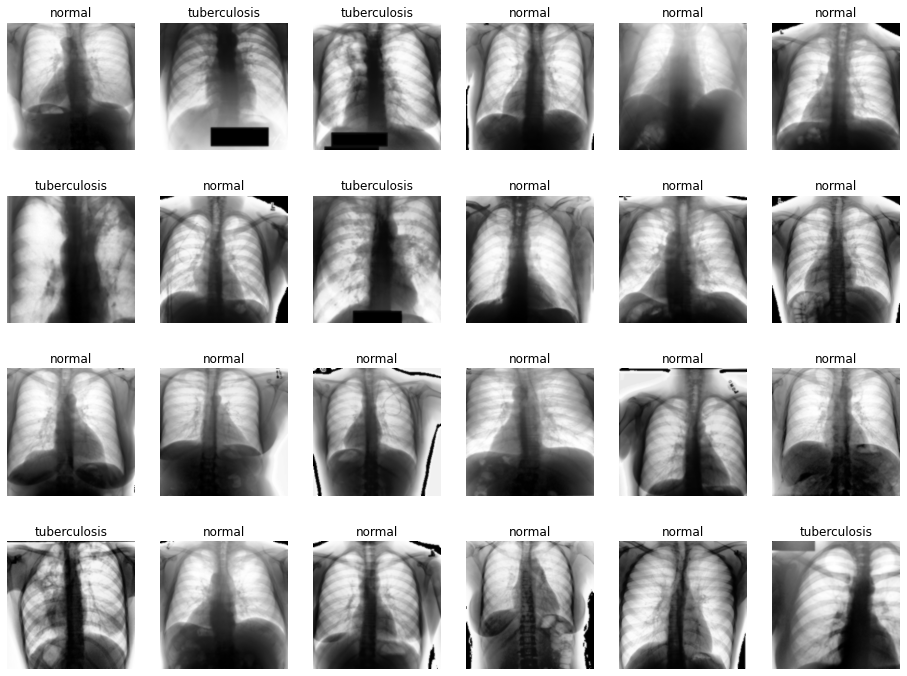

In [7]:
samples, labels = iter(train_loader).next()
classes = {0:'normal', 1:'tuberculosis'}
fig = plt.figure(figsize=(16,24))


for i in range(24):
    a = fig.add_subplot(4,6,i+1)
    a.set_title(classes[labels[i].item()])
    a.axis('off')
    a.imshow(np.transpose(samples[i].numpy(), (1,2,0)))
    
plt.subplots_adjust(bottom=0.2, top=0.6, hspace=0)
print(samples[i].shape)
print(labels[i].shape)



In [8]:
device='cuda' if torch.cuda.is_available() else 'cpu'
print(device)


cuda


In [9]:
import torch
import torch.nn as nn 
import torch.nn.functional as F

import numpy as np 
from einops import rearrange, repeat, reduce
from timm.models.layers import DropPath, trunc_normal_
import math


"""
This file contains all operations about building CMT model
paper: <CMT: Convolutional Neural Networks Meet Vision Transformers>
addr: https://arxiv.org/abs/2107.06263
NOTE: In the paper, in Table 1, authors denote Patch Aggregation and LPU may have different channels,
but in practice, in LPU, residual connection is need, so difference in channels may make summation
impossible, therefore, we use the same channels between Patch Aggregation and LPU. So calculated number of
params differ a little from the paper.
Update: The new version of architecture is released to fix the above bugs.
Created by Kunhong Yu
Date: 2021/07/14
"""

import torch as t
from torch.nn import functional as F
#########################
#  0. Patch Aggregation #
#########################
class PatchAggregation(t.nn.Module):
    """Define Bridge/PatchAggregation module connecting each other module
    can be found in Figure 2(c) and Table 1
    """

    def __init__(self, in_channels = 16, out_channels = 46):
        """
        Args :
            --in_channels: default is 16
            --out_channels: default is 46
        """
        super(PatchAggregation, self).__init__()

        self.pa = t.nn.Sequential(
            t.nn.Conv2d(in_channels = in_channels, out_channels = out_channels,
                        kernel_size = 2, stride = 2),
        )
        # self.ln = t.nn.LayerNorm(out_channels)

    def forward(self, x):

        x = self.pa(x)
        b, c, h, w = x.size()
        x = F.layer_norm(x, (c, h, w))

        return x


#########################
#       1. Stem         #
#########################
class Stem(t.nn.Module):
    """Define Stem module
    can be found in Figure 2(c) and Table 1
    """

    def __init__(self, in_channels = 3, out_channels = 16):
        """
        Args :
            --in_channels: default is 3
            --out_channels: default is 16
        """
        super(Stem, self).__init__()

        self.stem = t.nn.Sequential(
            # 1.1 One Conv layer
            t.nn.Conv2d(in_channels = in_channels, out_channels = out_channels, kernel_size = 3,
                        stride = 2, padding = 1),
            t.nn.BatchNorm2d(out_channels),
            t.nn.GELU(), # 112 x 112 x 16

            # 1.2 Two subsequent Conv layers
            t.nn.Conv2d(in_channels = out_channels, out_channels = out_channels, kernel_size = 3,
                        stride = 1, padding = 1),
            t.nn.BatchNorm2d(out_channels),
            t.nn.GELU(), # 112 x 112 x 16
            t.nn.Conv2d(in_channels = out_channels, out_channels = out_channels, kernel_size = 3,
                        stride = 1, padding = 1),
            t.nn.BatchNorm2d(out_channels),
            t.nn.GELU() # 112 x 112 x 16
        )

    def forward(self, x):

        x = self.stem(x)

        return x


#########################
#     3. CMT block      #
#########################
#*************
#  3.1 LPU   #
#*************
class LPU(t.nn.Module):
    """Define Local Perception Unit
    can be found in Figure 2(c) and Table 1
    """

    def __init__(self, in_channels = 46):
        """
        Args :
            --in_channels: default is 46
        """
        super(LPU, self).__init__()

        out_channels = in_channels
        self.dwconv = t.nn.Sequential(
            t.nn.Conv2d(in_channels = in_channels, out_channels = out_channels, groups = in_channels,
                        kernel_size = 3, stride = 1, padding = 1) # 112 x 112 x 46
        )

    def forward(self, x):

        x = x + self.dwconv(x)

        return x


#*************
#  3.2 LMHSA #
#*************
class LMHSA(t.nn.Module):
    """Define Lightweight MHSA module
    can be found in Figure 2(c) and Table 1
    """

    def __init__(self, input_size, kernel_size, d_k, d_v, num_heads, in_channels = 46):
        """
        Args :
            --input_size
            --kernel_size: for DWConv
            --d_k: dimension for key and query
            --d_v: dimension for value
            --num_heads: attention heads
            --in_channels: default is 46
        """
        super(LMHSA, self).__init__()

        stride = kernel_size
        self.dwconv = t.nn.Sequential(
            t.nn.Conv2d(in_channels = in_channels, out_channels = in_channels, groups = in_channels,
                        kernel_size = kernel_size, stride = stride)
        ) # (112 / kernel_size) x (112 x kernel_size) x 46

        self.query = t.nn.Sequential(
            t.nn.Linear(in_channels, d_k * num_heads)
        )

        self.key = t.nn.Sequential(
            t.nn.Linear(in_channels, d_k * num_heads)
        )

        self.value = t.nn.Sequential(
            t.nn.Linear(in_channels, d_v * num_heads)
        )

        self.B = t.nn.Parameter(t.rand(1, num_heads, input_size ** 2, (input_size // kernel_size) ** 2), requires_grad = True)
        self.num_heads = num_heads
        self.d_k = d_k
        self.d_v = d_v
        self.scale = math.sqrt(self.d_k)
        self.softmax = t.nn.Softmax(dim = -1)
        self.LN = t.nn.LayerNorm(in_channels)

    def forward(self, x):
        """x has shape [m, c, h, w]"""
        b, c, h, w = x.size()
        x_ = x

        # i. reshape
        x_reshape = x.view(b, c, h * w).permute(0, 2, 1) # [m, h * w, c]
        x_reshape = self.LN(x_reshape)

        # ii. Get key, query and value
        q = self.query(x_reshape) # [m, h * w, d_k * num_heads]
        q = q.view(b, h * w, self.num_heads, self.d_k).permute(0, 2, 1, 3) # [m, num_heads, h * w, d_k]

        k = self.dwconv(x) # [m, c, h', w']
        c_, h_, w_ = k.size(1), k.size(-2), k.size(-1)
        k = k.view(b, c_, h_ * w_).permute(0, 2, 1) # [m, h' * w', c]
        k = self.key(k) # [m, h' * w', d_k * num_heads]
        k = k.view(b, h_ * w_, self.num_heads, self.d_k).permute(0, 2, 1, 3) # [m, num_heads, h' * w', d_k]

        v = self.dwconv(x)  # [m, c, h', w']
        v = v.view(b, c_, h_ * w_).permute(0, 2, 1)  # [m, h' * w', c]
        v = self.value(v)  # [m, h' * w', d_v * num_heads]
        v = v.view(b, h_ * w_, self.num_heads, self.d_v).permute(0, 2, 1, 3)  # [m, num_heads, h' * w', d_v]

        # iii. LMHSA
        logit = t.matmul(q, k.transpose(-2, -1)) / self.scale # [m, num_heads, h * w, h' * w']
        logit = logit + self.B
        attention = self.softmax(logit)
        attn_out = t.matmul(attention, v) # [m, num_heads, h * w, d_v]
        attn_out = attn_out.permute(0, 2, 1, 3) # [m, h * w, num_heads, d_v]
        attn_out = attn_out.reshape(b, h, w, self.num_heads * self.d_v).permute(0, -1, 1, 2) # [m, num_heads * d_v, h, w]

        return attn_out + x_


#*************
# 3.3 IRFFN  #
#*************
class IRFFN(t.nn.Module):
    """Define IRFNN module
    can be found in Figure 2(c) and Table 1
    """

    def __init__(self, in_channels = 46, R = 3.6):
        """
        Args :
            --in_channels: default is 46
            --R: expansion ratio, default is 3.6
        """
        super(IRFFN, self).__init__()

        exp_channels = int(in_channels * R)
        self.conv1 = t.nn.Sequential(
            t.nn.Conv2d(in_channels = in_channels, out_channels = exp_channels, kernel_size = 1),
            t.nn.BatchNorm2d(exp_channels),
            t.nn.GELU()
        ) # 112 x 112 x exp_channels

        self.dwconv = t.nn.Sequential(
            t.nn.Conv2d(in_channels = exp_channels, out_channels = exp_channels, groups = exp_channels,
                        kernel_size = 3, stride = 1, padding = 1),
            t.nn.BatchNorm2d(exp_channels),
            t.nn.GELU()
        ) # 112 x 112 x exp_channels

        self.conv2 = t.nn.Sequential(
            t.nn.Conv2d(in_channels = exp_channels, out_channels = in_channels, kernel_size = 1),
            t.nn.BatchNorm2d(in_channels)
        ) # 112 x 112 x 46

    def forward(self, x):

        _, c, h, w = x.size()
        x_ = F.layer_norm(x, (c, h, w))

        x_ = self.conv2(self.dwconv(self.conv1(x_)))

        return x + x_


#*************
#3.4 CMT block#
#*************
class CMTBlock(t.nn.Module):
    """Define CMT block"""

    def __init__(self, input_size, kernel_size, d_k, d_v, num_heads, R = 3.6, in_channels = 46):
        """
        Args :
            --input_size
            --kernel_size: for DWConv
            --d_k: dimension for key and query
            --d_v: dimension for value
            --num_heads: attention heads
            --R: expansion ratio, default is 3.6
            --in_channels: default is 46
        """
        super(CMTBlock, self).__init__()

        # 1. LPU
        self.lpu = LPU(in_channels = in_channels)

        # 2. LMHSA
        self.lmhsa = LMHSA(input_size = input_size,
                           kernel_size = kernel_size, d_k = d_k, d_v = d_v, num_heads = num_heads,
                           in_channels = in_channels)

        # 3. IRFFN
        self.irffn = IRFFN(in_channels = in_channels, R = R)

    def forward(self, x):

        x = self.lpu(x)
        x = self.lmhsa(x)
        x = self.irffn(x)

        return x
    
    
    
    
#########################
#   CMT Configuration   #
#########################
class CMT(t.nn.Module):
    """Define CMT model"""

    def __init__(self,
                 in_channels = 3,
                 stem_channels = 16,
                 cmt_channelses = [46, 92, 184, 368],
                 pa_channelses = [46, 92, 184, 368],
                 R = 3.6,
                 repeats = [2, 2, 10, 2],
                 input_size = 224,
                 num_classes = 1000):
        """
        Args :
            --in_channels: default is 3
            --stem_channels: stem channels, default is 16
            --cmt_channelses: list, default is [46, 92, 184, 368]
            --pa_channels: patch aggregation channels, list, default is [46, 92, 184, 368]
            --R: expand ratio, default is 3.6
            --repeats: list, to specify how many CMT blocks stacked together, default is [2, 2, 10, 2]
            --input_size: default is 224
            --num_classes: default is 1000 for ImageNet
        """
        super(CMT, self).__init__()

        if input_size == 224:
            sizes = [56, 28, 14, 7]
        elif input_size == 160:
            sizes = [40, 20, 10, 5]
        elif input_size == 192:
            sizes = [48, 24, 12, 6]
        elif input_size == 256:
            sizes = [64, 32, 16, 8]
        elif input_size == 288:
            sizes = [72, 36, 18, 9]
        else:
            raise Exception('No other input sizes!')

        # 1. Stem
        self.stem = Stem(in_channels = in_channels, out_channels = stem_channels)

        # 2. Patch Aggregation 1
        self.pa1 = PatchAggregation(in_channels = stem_channels, out_channels = pa_channelses[0])
        self.pa2 = PatchAggregation(in_channels = cmt_channelses[0], out_channels = pa_channelses[1])
        self.pa3 = PatchAggregation(in_channels = cmt_channelses[1], out_channels = pa_channelses[2])
        self.pa4 = PatchAggregation(in_channels = cmt_channelses[2], out_channels = pa_channelses[3])

        # 3. CMT block
        cmt1 = []
        for _ in range(repeats[0]):
            cmt_layer = CMTBlock(input_size = sizes[0],
                                 kernel_size = 8,
                                 d_k = cmt_channelses[0],
                                 d_v = cmt_channelses[0],
                                 num_heads = 1,
                                 R = R, in_channels = pa_channelses[0])
            cmt1.append(cmt_layer)
        self.cmt1 = t.nn.Sequential(*cmt1)

        cmt2 = []
        for _ in range(repeats[1]):
            cmt_layer = CMTBlock(input_size = sizes[1],
                                 kernel_size = 4,
                                 d_k = cmt_channelses[1] // 2,
                                 d_v = cmt_channelses[1] // 2,
                                 num_heads = 2,
                                 R = R, in_channels = pa_channelses[1])
            cmt2.append(cmt_layer)
        self.cmt2 = t.nn.Sequential(*cmt2)

        cmt3 = []
        for _ in range(repeats[2]):
            cmt_layer = CMTBlock(input_size = sizes[2],
                                 kernel_size = 2,
                                 d_k = cmt_channelses[2] // 4,
                                 d_v = cmt_channelses[2] // 4,
                                 num_heads = 4,
                                 R = R, in_channels = pa_channelses[2])
            cmt3.append(cmt_layer)
        self.cmt3 = t.nn.Sequential(*cmt3)

        cmt4 = []
        for _ in range(repeats[3]):
            cmt_layer = CMTBlock(input_size = sizes[3],
                                 kernel_size = 1,
                                 d_k = cmt_channelses[3] // 8,
                                 d_v = cmt_channelses[3] // 8,
                                 num_heads = 8,
                                 R = R, in_channels = pa_channelses[3])
            cmt4.append(cmt_layer)
        self.cmt4 = t.nn.Sequential(*cmt4)

        # 4. Global Avg Pool
        self.avg = t.nn.AdaptiveAvgPool2d(1)

        # 5. FC
        self.fc = t.nn.Sequential(
            t.nn.Linear(cmt_channelses[-1], 1280),
            t.nn.ReLU(inplace = True) # we use ReLU here as default
        )

        # 6. Classifier
        self.classifier = t.nn.Sequential(
            t.nn.Linear(1280, num_classes)
        )

    def forward(self, x):

        # 1. Stem
        x_stem = self.stem(x)

        # 2. PA1 + CMTb1
        x_pa1 = self.pa1(x_stem)
        x_cmtb1 = self.cmt1(x_pa1)

        # 3. PA2 + CMTb2
        x_pa2 = self.pa2(x_cmtb1)
        x_cmtb2 = self.cmt2(x_pa2)

        # 4. PA3 + CMTb3
        x_pa3 = self.pa3(x_cmtb2)
        x_cmtb3 = self.cmt3(x_pa3)

        # 5. PA4 + CMTb4
        x_pa4 = self.pa4(x_cmtb3)
        x_cmtb4 = self.cmt4(x_pa4)

        # 6. Avg
        x_avg = self.avg(x_cmtb4)
        x_avg = x_avg.squeeze()

        # 7. Linear + Classifier
        x_fc = self.fc(x_avg)
        out = self.classifier(x_fc)

        return out



#########################
#      CMT Models       #
#########################
# 1. CMT-Ti
class CMT_Ti(t.nn.Module):
    """Define CMT-Ti model"""

    def __init__(self, in_channels = 3, input_size = 224, num_classes = 1000):
        """
        Args :
            --in_channels: default is 3
            --input_size: default is 224
            --num_classes: default is 1000 for ImageNet
        """
        super(CMT_Ti, self).__init__()

        self.cmt_ti = CMT(in_channels = in_channels,
                          stem_channels = 16,
                          cmt_channelses = [46, 92, 184, 368],
                          pa_channelses = [46, 92, 184, 368],
                          R = 3.6,
                          repeats = [2, 2, 10, 2],
                          input_size = input_size,
                          num_classes = num_classes)

    def forward(self, x):

        x = self.cmt_ti(x)

        return x


# 2. CMT-XS
class CMT_XS(t.nn.Module):
    """Define CMT-XS model"""

    def __init__(self, in_channels = 3, input_size = 224, num_classes = 2):
        """
        Args :
            --in_channels: default is 3
            --input_size: default is 224
            --num_classes: default is 1000 for ImageNet
        """
        super(CMT_XS, self).__init__()

        self.cmt_xs = CMT(in_channels = in_channels,
                          stem_channels = 16,
                          cmt_channelses = [52, 104, 208, 416],
                          pa_channelses = [52, 104, 208, 416],
                          R = 3.8,
                          repeats = [3, 3, 12, 3],
                          input_size = input_size,
                          num_classes = num_classes)

    def forward(self, x):

        x = self.cmt_xs(x)

        return x


# 3. CMT-S
class CMT_S(t.nn.Module):
    """Define CMT-S model"""

    def __init__(self, in_channels = 3, input_size = 224, num_classes = 2):
        """
        Args :
            --in_channels: default is 3
            --input_size: default is 224
            --num_classes: default is 1000 for ImageNet
        """
        super(CMT_S, self).__init__()

        self.cmt_s = CMT(in_channels = in_channels,
                         stem_channels = 32,
                         cmt_channelses = [64, 128, 256, 512],
                         pa_channelses = [64, 128, 256, 512],
                         R = 4.,
                         repeats = [3, 3, 16, 3],
                         input_size = input_size,
                         num_classes = num_classes)

    def forward(self, x):

        x = self.cmt_s(x)

        return x


# 4. CMT-B
class CMT_B(t.nn.Module):
    """Define CMT-B model"""

    def __init__(self, in_channels = 3, input_size = 224, num_classes = 1000):
        """
        Args :
            --in_channels: default is 3
            --input_size: default is 224
            --num_classes: default is 1000 for ImageNet
        """
        super(CMT_B, self).__init__()

        self.cmt_b = CMT(in_channels = in_channels,
                         stem_channels = 38,
                         cmt_channelses = [76, 152, 304, 608],
                         pa_channelses = [76, 152, 304, 608],
                         R = 4.,
                         repeats = [4, 4, 20, 4],
                         input_size = input_size,
                         num_classes = num_classes)

    def forward(self, x):

        x = self.cmt_b(x)

        return x


if __name__ == "__main__":
    x = torch.randn(1, 3, 224, 224)
    model = CMT_XS()

    print(model)
    out = model(x)
    print(out.shape)

CMT_XS(
  (cmt_xs): CMT(
    (stem): Stem(
      (stem): Sequential(
        (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): GELU()
        (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): GELU()
        (6): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (7): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (8): GELU()
      )
    )
    (pa1): PatchAggregation(
      (pa): Sequential(
        (0): Conv2d(16, 52, kernel_size=(2, 2), stride=(2, 2))
      )
    )
    (pa2): PatchAggregation(
      (pa): Sequential(
        (0): Conv2d(52, 104, kernel_size=(2, 2), stride=(2, 2))
      )
    )
    (pa3): PatchAggregation(
      (pa): Sequential(
        (0): Conv2d(104, 208

torch.Size([2])


In [10]:
batch_size = 16
num_classes = 2

model.to(device)



CMT_XS(
  (cmt_xs): CMT(
    (stem): Stem(
      (stem): Sequential(
        (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): GELU()
        (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): GELU()
        (6): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (7): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (8): GELU()
      )
    )
    (pa1): PatchAggregation(
      (pa): Sequential(
        (0): Conv2d(16, 52, kernel_size=(2, 2), stride=(2, 2))
      )
    )
    (pa2): PatchAggregation(
      (pa): Sequential(
        (0): Conv2d(52, 104, kernel_size=(2, 2), stride=(2, 2))
      )
    )
    (pa3): PatchAggregation(
      (pa): Sequential(
        (0): Conv2d(104, 208

In [11]:
!pip install torchsummary
from torchsummary import summary




model.cuda()
summary(model, input_size=(3,224,224))


Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 112, 112]             448
       BatchNorm2d-2         [-1, 16, 112, 112]              32
              GELU-3         [-1, 16, 112, 112]               0
            Conv2d-4         [-1, 16, 112, 112]           2,320
       BatchNorm2d-5         [-1, 16, 112, 112]              32
              GELU-6         [-1, 16, 112, 112]               0
            Conv2d-7         [-1, 16, 112, 112]           2,320
       BatchNorm2d-8         [-1, 16, 112, 112]              32
              GELU-9         [-1, 16, 112, 112]               0
             Stem-10         [-1, 16, 112, 112]               0
           Conv2d-11           [-1, 52, 56, 56]           3,380
 PatchAggregation-12           [-1, 52, 56, 56]               0
           Conv2d-13          

In [12]:
def fit(model, criterion, optimizer, epochs, train_loader, valid_loader):
    model.train()
    train_loss = 0
    train_acc = 0
    train_correct = 0
    
    train_losses = []
    train_accuracies = []
    valid_losses = []
    valid_accuracies = []
    
    for epoch in range(epochs):
        start = time.time()
        
        for train_x, train_y in train_loader:
            model.train()
            #train_y = train_y.type(torch.LongTensor)
            train_y = train_y.squeeze(1)
            train_x, train_y = train_x.to(device), train_y.to(device).long()
            optimizer.zero_grad()
            pred = model(train_x)
            _, preds = torch.max(pred, 1)
            #print(pred.shape)
            #print(train_y.shape)
            #print(pred.shape)
            loss = criterion(pred, train_y)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            #running_corrects += torch.sum(preds == labels.data)
            train_correct += torch.sum(preds.cpu() == train_y.data.cpu())
        #scheduler.step()
            #y_pred = pred.cpu()
            #print(y_pred)
            #y_pred[y_pred >= 0.5] = 1
            #y_pred[y_pred < 0.5] = 0
           
            
        # validation data check
        valid_loss = 0
        valid_acc = 0
        valid_correct = 0
        for valid_x, valid_y in valid_loader:
            with torch.no_grad():
                model.eval()
                #valid_y = valid_y.type(torch.LongTensor)
                valid_y = valid_y.squeeze(1)
                valid_x, valid_y = valid_x.to(device), valid_y.to(device).long()
                pred = model(valid_x)
                _, preds_val = torch.max(pred, 1)
                loss = criterion(pred, valid_y)
            valid_loss += loss.item()
            
            #running_corrects += torch.sum(preds == labels.data)
            valid_correct += torch.sum(preds_val.cpu() == valid_y.data.cpu())
            
            #y_pred = pred.cpu()
            #y_pred[y_pred >= 0.5] = 1
            #y_pred[y_pred < 0.5] = 0
            #valid_correct += y_pred.eq(valid_y.cpu()).int().sum()
            
        train_acc = train_correct/len(train_loader.dataset)
        valid_acc = valid_correct/len(valid_loader.dataset)
        print(f'{time.time() - start:.3f}sec : [Epoch {epoch+1}/{epochs}] -> train loss: {train_loss/len(train_loader):.4f}, train acc: {train_acc*100:.3f}% / valid loss: {valid_loss/len(valid_loader):.4f}, valid acc: {valid_acc*100:.3f}%')
        train_losses.append(train_loss/len(train_loader))
        train_accuracies.append(train_acc)
        valid_losses.append(valid_loss/len(valid_loader))
        valid_accuracies.append(valid_acc)
        
        train_loss = 0
        train_acc = 0
        train_correct = 0
    plt.plot(train_losses, label='loss')
    plt.plot(train_accuracies, label='accuracy')
    plt.legend()
    plt.title('train loss and accuracy')
    plt.show()
    plt.plot(valid_losses, label='loss')
    plt.plot(valid_accuracies, label='accuracy')
    plt.legend()
    plt.title('valid loss and accuracy')
    plt.show()



In [ ]:
import torch.optim as optim
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr = 0.0005)
fit(model, criterion, optimizer, 60, train_loader, test_loader)



50.886sec : [Epoch 1/60] -> train loss: 0.2776, train acc: 89.643% / valid loss: 0.1328, valid acc: 94.869%
50.892sec : [Epoch 2/60] -> train loss: 0.1735, train acc: 93.393% / valid loss: 0.2812, valid acc: 86.874%
51.179sec : [Epoch 3/60] -> train loss: 0.1436, train acc: 94.583% / valid loss: 0.1478, valid acc: 95.585%
50.567sec : [Epoch 4/60] -> train loss: 0.1460, train acc: 94.732% / valid loss: 0.1185, valid acc: 94.630%
50.582sec : [Epoch 5/60] -> train loss: 0.1177, train acc: 96.161% / valid loss: 0.1292, valid acc: 95.107%
50.782sec : [Epoch 6/60] -> train loss: 0.1243, train acc: 95.536% / valid loss: 0.1330, valid acc: 95.227%
50.304sec : [Epoch 7/60] -> train loss: 0.1283, train acc: 95.506% / valid loss: 0.2434, valid acc: 92.721%
50.279sec : [Epoch 8/60] -> train loss: 0.1201, train acc: 95.774% / valid loss: 0.1322, valid acc: 94.988%
50.769sec : [Epoch 9/60] -> train loss: 0.1083, train acc: 96.369% / valid loss: 0.1303, valid acc: 95.465%
50.848sec : [Epoch 10/60] ->